In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from functools import partial
from scipy.optimize import minimize, fsolve, basinhopping
import tqdm
import yfinance as yf
# import yahoo_fin.options as ops
import cmath

%matplotlib inline

plt.style.use('ggplot')
# sns.set_palette('mako')
# sns.set_style('darkgrid')

In [192]:
import matplotlib as mpl
#set params for the article
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.labelsize'] = 20

#set params for the notebook
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
# mpl.rcParams['legend.fontsize'] = 10
# mpl.rcParams['axes.labelsize'] = 14

## DCL process

In [99]:
def dclProcess(NumberPaths, N, T, x0, theta, delta):
    Z1 = np.random.normal(0.0, 1.0,[NumberPaths,N])
    X = np.zeros([NumberPaths, N + 1])

    X[:, 0] = x0

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] - 1/theta * X[:,i] * dt + np.sqrt((1 - (X[:, i])**2)/(theta * (delta + 1))) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] > 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] < -1)[0], i+1] = -0.9999 
            
        time[i+1] = time[i] + dt

    return time, X

In [200]:
rho0 = 0.1
theta = 1
delta = 4
time, dclpaths = dclProcess(50, 3000, 1, rho0, theta, delta)

In [201]:
psi = lambda t: np.sqrt(1 - (1/(2*(delta+1)+1) + (rho0**2 - 1/(2*(delta+1)+1)) * np.exp(-(2*(delta+1)+1)/(theta*(delta+1))*t) -\
    rho0**4 * np.exp(-4/theta * t))/(1 - (np.exp(-1/theta * t) * rho0)**2))

exp_dcl = lambda t: np.exp(-1/theta * t)*rho0
var_dcl = lambda t: 1/(theta*(delta+1)) * (psi(t)**2) * (1 - np.exp(-2*t / theta))

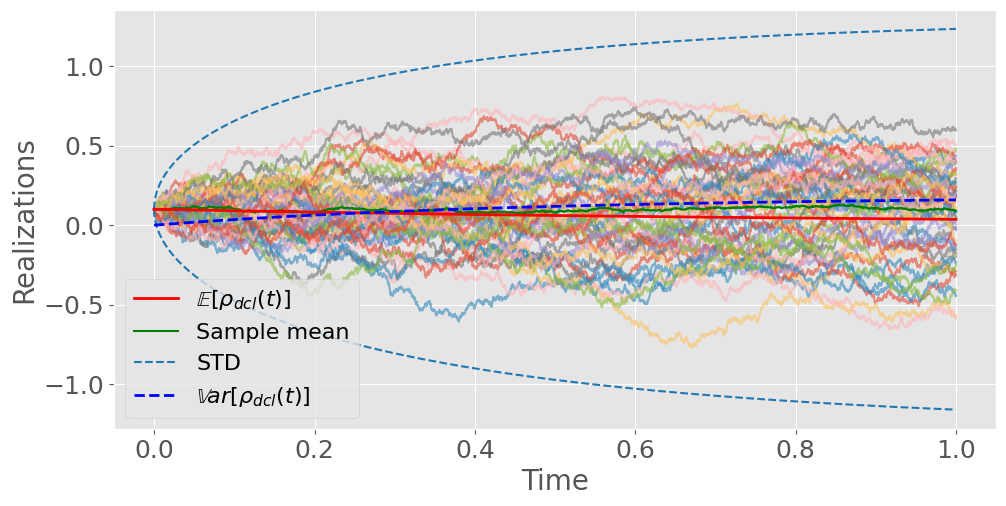

In [202]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(50):
    plt.plot(time, dclpaths[i], alpha=0.6)
        
# plt.title('DCL Process')
plt.xlabel('Time')
plt.ylabel('Realizations')

plt.plot(time, exp_dcl(time), color='red', label=r'$\mathbb{E}[\rho_{dcl}(t)]$', linewidth=2, zorder=3)
plt.plot(time, np.mean(dclpaths, 0), color='green', label='Sample mean')
plt.plot(time, exp_dcl(time) + 3 * np.sqrt(var_dcl(time)), '--', color='tab:blue', label='STD')
plt.plot(time, exp_dcl(time) - 3 * np.sqrt(var_dcl(time)), '--', color='tab:blue')
# plt.plot(time, [3*np.sqrt(2/(theta*(2*(delta+1)+1)))]*len(time))
plt.plot(time, var_dcl(time), '--', color='blue', label=r'$\mathbb{V}ar[\rho_{dcl}(t)]$', linewidth=2, zorder=3)


plt.legend()
plt.tight_layout(pad=0.5)

# plt.savefig('Images/3sigma_DCL.pdf', dpi=300)
plt.show()

### Approximation for $\mathbb{E}[\rho^2(t)]$

In [103]:
def dclProcess_2moment(NumberPaths, N, T, x0, theta, delta):
    Z1 = np.random.normal(0.0, 1.0,[NumberPaths,N])
    X = np.zeros([NumberPaths, N + 1])

    X[:, 0] = x0

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] - 1/theta * X[:,i] * dt + np.sqrt((1 - (X[:, i])**2)/(theta * (delta + 1))) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] > 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] < -1)[0], i+1] = -0.9999 
            
        time[i+1] = time[i] + dt
        
    # X[:,1:] = X[:,1:]**2

    return time, X**2

In [104]:
rho0 = 0.1
theta = 2
delta = 3
time, dclpaths = dclProcess_2moment(10, 3000, 1, rho0, theta, delta)

In [105]:
exp_sec_moment = lambda t: 1/(2*(delta+1)+1) + (rho0**2 - 1/(2*(delta+1)+1)) * np.exp(-(2*(delta+1)+1)/(theta*(delta+1)) * t)

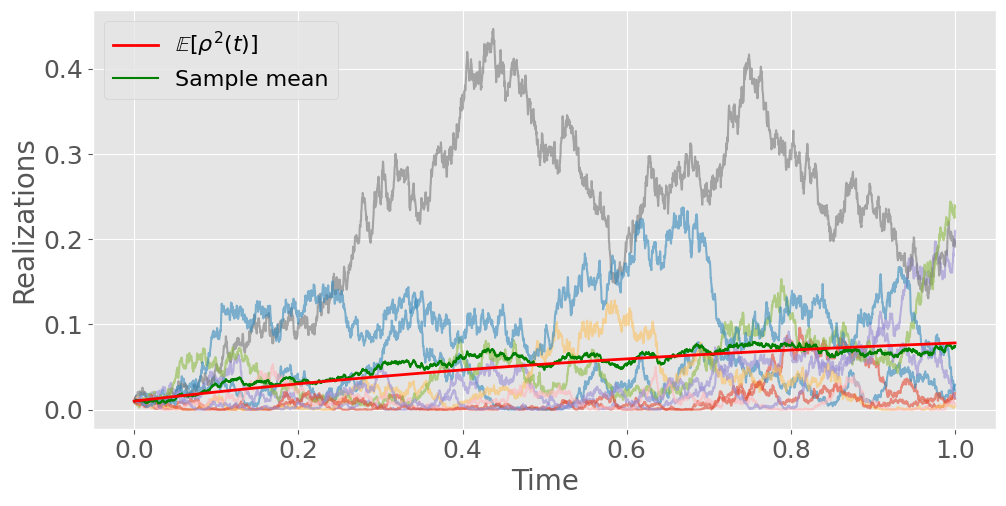

In [106]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(10):
    plt.plot(time, dclpaths[i], alpha=0.6)
        
# plt.title('DCL Process')
plt.xlabel('Time')
plt.ylabel('Realizations')

plt.plot(time, exp_sec_moment(time),\
                    color='red', label=r'$\mathbb{E}[\rho^2(t)]$', linewidth=2, zorder=3)
plt.plot(time, np.mean(dclpaths, 0), color='green', label='Sample mean')
plt.legend()

plt.tight_layout(pad=0.5)
# plt.savefig('Images/Approx_sec_moment_DCL.pdf', dpi=300)
plt.show()

Comparison with more realizations

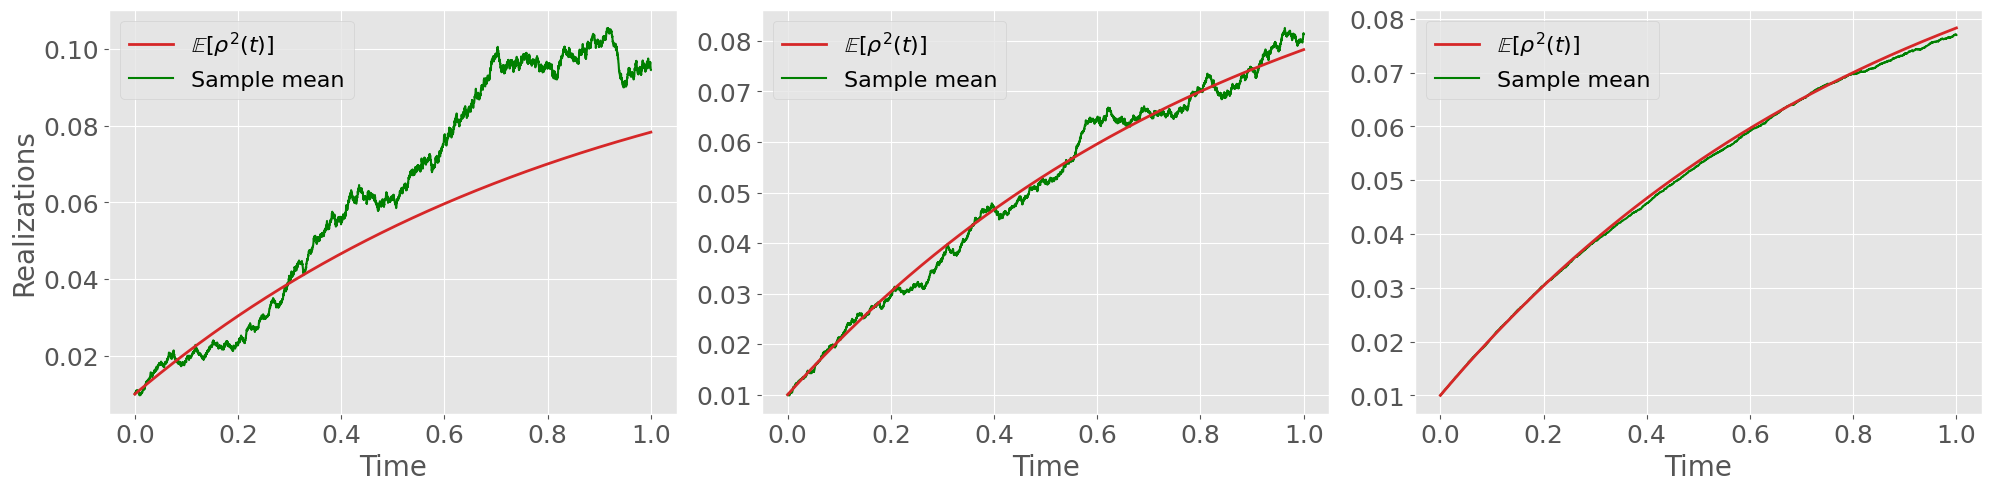

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

num_samples = [50, 200, 10_000]

for i in range(len(num_samples)):
    time, dclpaths = dclProcess_2moment(num_samples[i], 5000, 1, rho0, theta, delta)

    axs[i].set_xlabel('Time')
    axs[0].set_ylabel('Realizations')

    axs[i].plot(time, exp_sec_moment(time), color='tab:red', zorder=3, label=r'$\mathbb{E}[\rho^2(t)]$', linewidth=2)
    axs[i].plot(time, np.mean(dclpaths, 0), color='green', label='Sample mean')
    axs[i].legend()

plt.tight_layout(pad=1)
plt.subplots_adjust(wspace=0.15)
# plt.savefig('Images/Approx_sec_mom_DCL_3plots.pdf', dpi=300)
plt.show()

### Approximation for $\mathbb{E}[\sqrt{1 - \rho^2(t)}]$

In [109]:
def dclProcess_sqrt_rho_2(NumberPaths, N, T, x0, theta, delta):
    Z1 = np.random.normal(0.0, 1.0,[NumberPaths,N])
    X = np.zeros([NumberPaths, N + 1])

    X[:, 0] = x0

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] - 1/theta * X[:,i] * dt + np.sqrt((1 - (X[:, i])**2)/(theta * (delta + 1))) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] > 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] < -1)[0], i+1] = -0.9999 
            
        time[i+1] = time[i] + dt
        
    # X[:,1:] = X[:,1:]**2

    return time, np.sqrt(1 - X**2)

In [110]:
rho0 = 0.8
theta = 1
delta = 10
time, dclpaths = dclProcess_sqrt_rho_2(10, 5000, 1, rho0, theta, delta)

In [111]:
psi = lambda t: np.sqrt(1 - (1/(2*(delta+1)+1) + (rho0**2 - 1/(2*(delta+1)+1)) * np.exp(-(2*(delta+1)+1)/(theta*(delta+1))*t) - rho0**4 * np.exp(-4/theta * t))/(1 - (np.exp(-1/theta * t) * rho0)**2))

crho = np.sqrt(1 - 1/(2*(delta+1) + 1))
arho = np.sqrt( 1 - (rho0**2 - rho0**4)/(1 - rho0**2) ) - np.sqrt(1 - 1/(2*(delta+1)+1) )
brho = -np.log((psi(1) - crho)/arho)

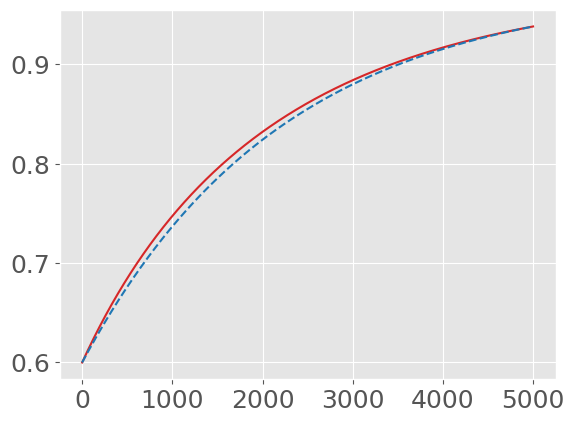

In [112]:
plt.plot(psi(time), color='tab:red')
plt.plot(arho * np.exp(-brho * time) + crho, '--', color='tab:blue')

plt.show()

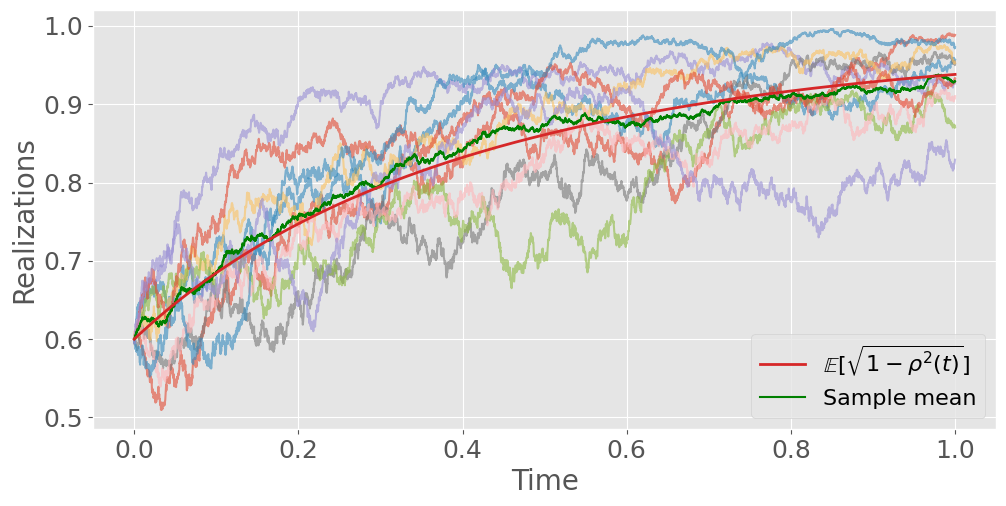

In [113]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(10):
    plt.plot(time, dclpaths[i], alpha=0.6)
        
# plt.title('DCL Process')
plt.xlabel('Time')
plt.ylabel('Realizations')

plt.plot(time, psi(time), color='tab:red', zorder=3, label=r'$\mathbb{E}[\sqrt{1-\rho^2(t)}]$', linewidth=2)
plt.plot(time, np.mean(dclpaths, 0), color='green', label='Sample mean')
plt.legend()

plt.tight_layout(pad=0.5)
# plt.savefig('Images/Approx_sqrt_DCL.pdf', dpi=300)
plt.show()

Comparison with more realizations

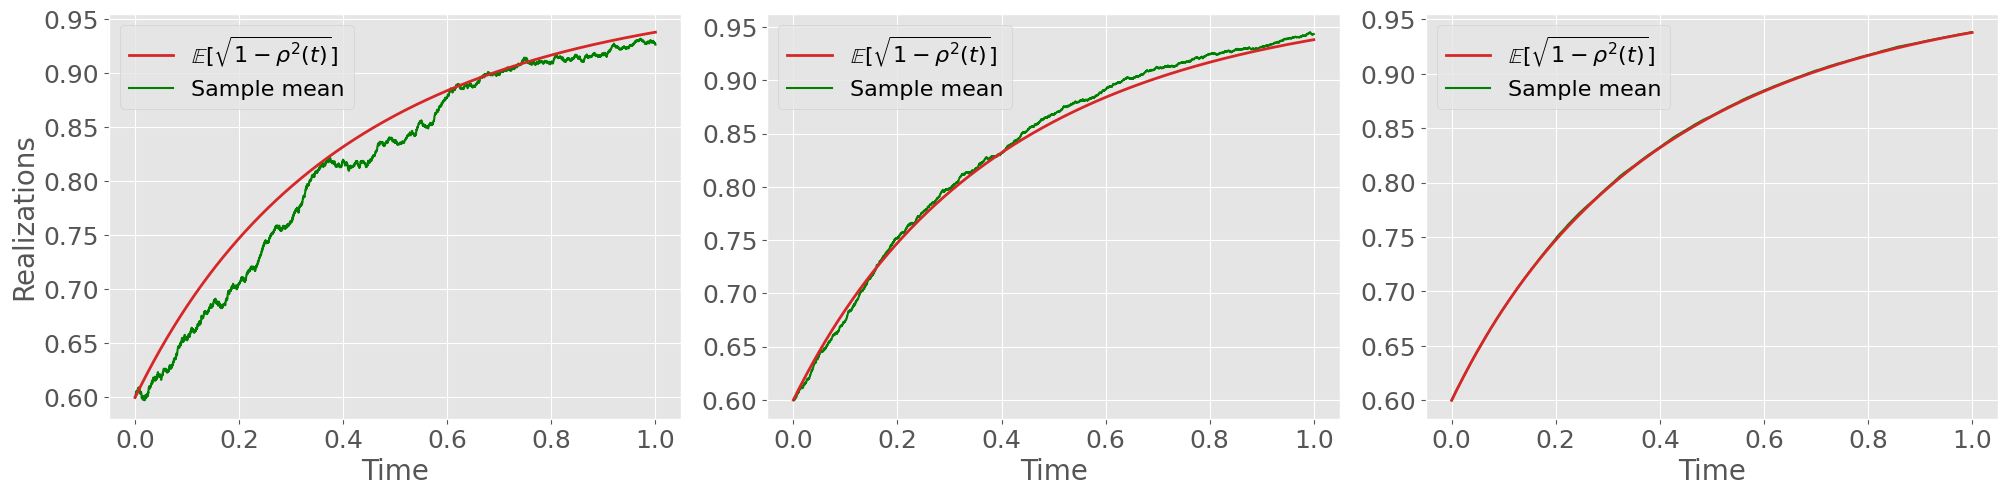

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

num_samples = [20, 100, 10_000]

for i in range(len(num_samples)):
    time, dclpaths = dclProcess_sqrt_rho_2(num_samples[i], 5000, 1, rho0, theta, delta)

    axs[i].set_xlabel('Time')
    axs[0].set_ylabel('Realizations')

    axs[i].plot(time, psi(time), color='tab:red', zorder=3, label=r'$\mathbb{E}[\sqrt{1-\rho^2(t)}]$', linewidth=2)
    axs[i].plot(time, np.mean(dclpaths, 0), color='green', label='Sample mean')
    axs[i].legend()

plt.tight_layout(pad=1)
plt.subplots_adjust(wspace=0.15)
# plt.savefig('Images/Approx_sqrt_DCL_3plots.pdf', dpi=300)
plt.show()

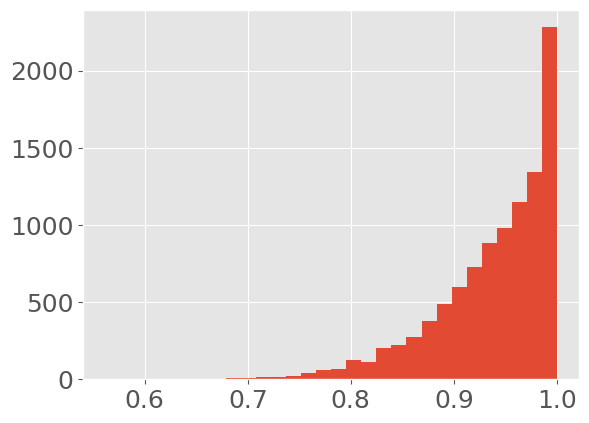

In [117]:
plt.hist(dclpaths[:, -1], bins=30)
plt.show()

## Jacobi process

In [193]:
def jacobiProcess(NumberPaths, N, T, x0, krho, murho, sigmarho):
    Z1 = np.random.normal(0.0, 1.0,[NumberPaths,N])
    X = np.zeros([NumberPaths, N + 1])

    X[:, 0] = x0

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] + krho * (murho - X[:,i]) * dt + sigmarho * np.sqrt(1-X[:,i]**2) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] > 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] < -1)[0], i+1] = -0.9999  
            
        time[i+1] = time[i] + dt

    return time, X

In [194]:
rho0 = 0.1
krho = 1
murho = 0.0
sigmarho = 0.62
time, jacobipath = jacobiProcess(100, 3000, 1, rho0, krho, murho, sigmarho)

In [195]:
mean_jac = lambda t: murho + np.exp(-krho * t) * (rho0 - murho)
C_jac = rho0**2 - (sigmarho**2 + 2*krho * murho**2) / (2*krho + sigmarho**2) - (2*krho*murho*(rho0 - murho)) / (krho + sigmarho**2)

exp_sec_moment_jac = lambda t: (sigmarho**2 + 2*krho * murho**2) / (2*krho + sigmarho**2) \
    + np.exp(-krho*t) * (2*krho*murho*(rho0 - murho)) / (krho + sigmarho**2) +\
    np.exp(-(2*krho + sigmarho**2)*t) * C_jac

psi_jac = lambda t: np.sqrt( 1 - (exp_sec_moment_jac(t) - (murho + np.exp(-krho * t) * (rho0 - murho))**4) / (1 - (murho + np.exp(-krho * t) * (rho0 - murho))**2)  )

var_jac = lambda t: (sigmarho**2)/(2*krho) * (1 - np.exp(-2*krho*t)) * psi_jac(t)**2

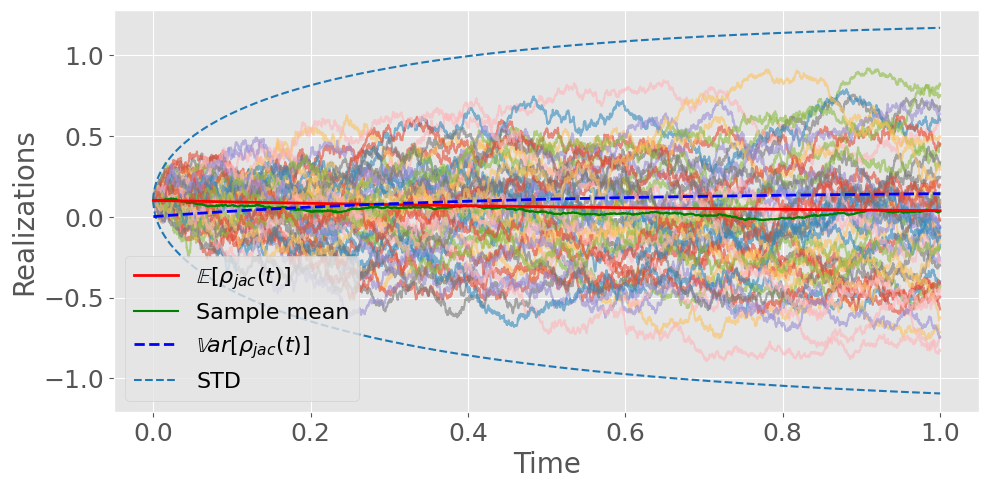

In [203]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(50):
    plt.plot(time, jacobipath[i], alpha=0.6)
        
    # plt.title('Jacobi Process')
    plt.xlabel('Time')
    plt.ylabel('Realizations')



plt.plot(time, mean_jac(time), color='red', label=r'$\mathbb{E}[\rho_{jac}(t)]$', zorder=3, linewidth=2)
plt.plot(time, np.mean(jacobipath, 0), color='green', label='Sample mean')
plt.plot(time, var_jac(time), '--', color='blue', label=r'$\mathbb{V}ar[\rho_{jac}(t)]$', linewidth=2, zorder=3)
plt.plot(time, mean_jac(time) + 3 * np.sqrt(var_jac(time)), '--', color='tab:blue', label='STD')
plt.plot(time, mean_jac(time) - 3 * np.sqrt(var_jac(time)), '--', color='tab:blue')

plt.legend()
plt.tight_layout(pad=1.1)
# plt.savefig('Images/sample_Jacobi.pdf', dpi=300)
plt.show()

In [122]:
def jacobiProcess_2(NumberPaths, N, T, x0, krho, murho, sigmarho):
    Z1 = np.random.normal(0.0, 1.0,[NumberPaths,N])
    X = np.zeros([NumberPaths, N + 1])

    X[:, 0] = x0

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] + krho * (murho - X[:,i]) * dt + sigmarho * np.sqrt(1-X[:,i]**2) * np.sqrt(dt) * Z1[:,i]
            
        # if (X[:,i+1] > 1).any():
        #     X[np.where(X[:,i+1] > 1)[0], i+1] = 0.9999

        # if (X[:,i+1] < -1).any():
        #     X[np.where(X[:,i+1] < -1)[0], i+1] = -0.9999  
            
        time[i+1] = time[i] + dt

    return time, X**2

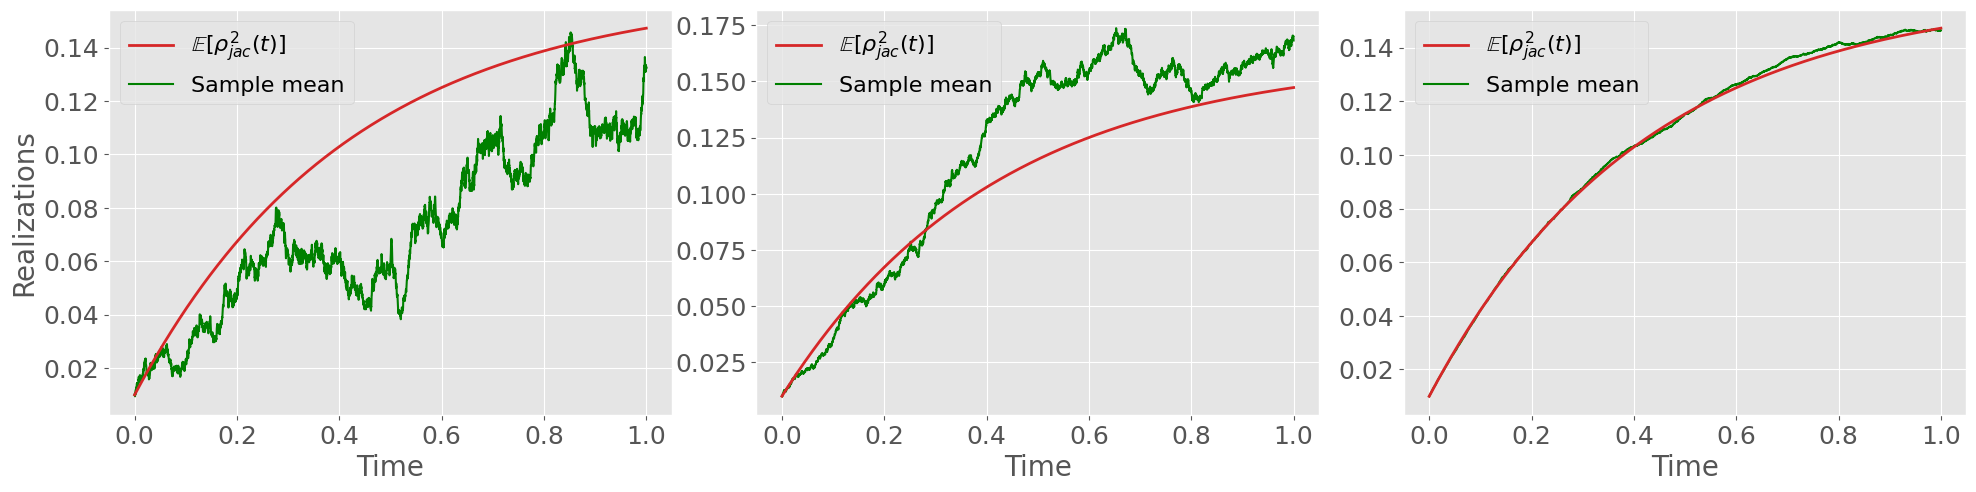

In [124]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

num_samples = [20, 100, 10_000]

for i in range(len(num_samples)):
    time, jacobipath_2 = jacobiProcess_2(num_samples[i], 5000, 1, rho0, krho, murho, sigmarho)

    axs[i].set_xlabel('Time')
    axs[0].set_ylabel('Realizations')

    axs[i].plot(time, exp_sec_moment_jac(time), color='tab:red', zorder=3, label=r'$\mathbb{E}[\rho_{jac}^2(t)]$', linewidth=2)
    axs[i].plot(time, np.mean(jacobipath_2, 0), color='green', label='Sample mean')
    axs[i].legend()

plt.tight_layout(pad=1)
plt.subplots_adjust(wspace=0.15)
# plt.savefig('Images/Approx_2_Jacobi_3plots.pdf', dpi=300)
plt.show()

### Approximation for $\mathbb{E}[\sqrt{1 - \rho_{jac}^2(t)}]$

In [162]:
def jacobiProcess_sqrt(NumberPaths, N, T, x0, krho, murho, sigmarho):
    Z1 = np.random.normal(0.0, 1.0, [NumberPaths,N])
    X = np.zeros([NumberPaths, N + 1])

    X[:, 0] = x0

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] + krho * (murho - X[:,i]) * dt + sigmarho * np.sqrt(1-X[:,i]**2) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] > 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] < -1)[0], i+1] = -0.9999  
            
        time[i+1] = time[i] + dt

    return time, np.sqrt(1 - X**2)

In [181]:
rho0 = 0.1
krho = 1
murho = 0.0
sigmarho = 0.62
time, jacobipath_sqrt = jacobiProcess_sqrt(100, 5000, 1, rho0, krho, murho, sigmarho)

In [182]:
mean_jac = lambda t: murho + np.exp(-krho * t) * (rho0 - murho)
C_jac = rho0**2 - (sigmarho**2 + 2*krho * murho**2) / (2*krho + sigmarho**2) - (2*krho*murho*(rho0 - murho)) / (krho + sigmarho**2)

exp_sec_moment_jac = lambda t: (sigmarho**2 + 2*krho * murho**2) / (2*krho + sigmarho**2) \
    + np.exp(-krho*t) * (2*krho*murho*(rho0 - murho)) / (krho + sigmarho**2) +\
    np.exp(-(2*krho + sigmarho**2)*t) * C_jac

psi_jac = lambda t: np.sqrt( 1 - (exp_sec_moment_jac(t) - (murho + np.exp(-krho * t) * (rho0 - murho))**4) / (1 - (murho + np.exp(-krho * t) * (rho0 - murho))**2)  )


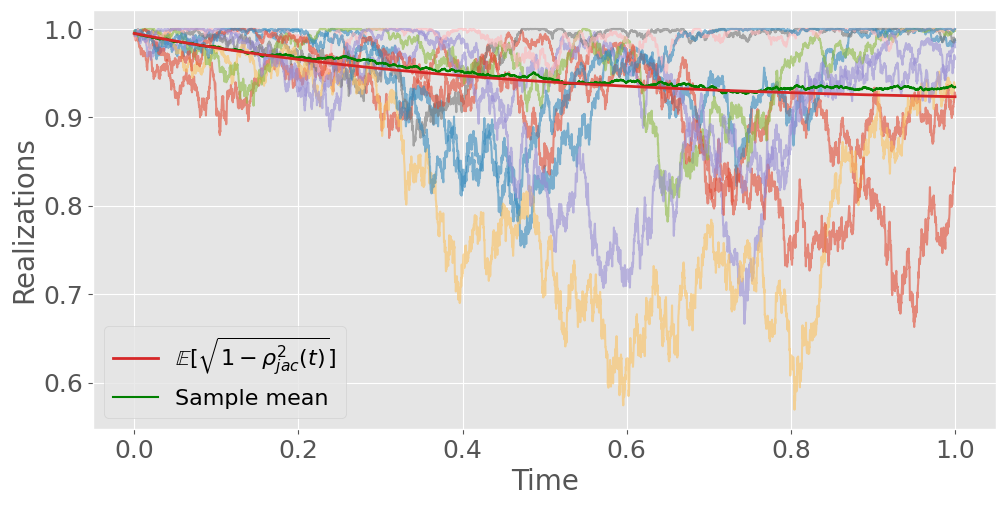

In [183]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(10):
    plt.plot(time, jacobipath_sqrt[i], alpha=0.6)
        
# plt.title('DCL Process')
plt.xlabel('Time')
plt.ylabel('Realizations')

plt.plot(time, psi_jac(time), color='tab:red', zorder=3, label=r'$\mathbb{E}[\sqrt{1-\rho_{jac}^2(t)}]$', linewidth=2)
plt.plot(time, np.mean(jacobipath_sqrt, 0), color='green', label='Sample mean')
plt.legend()

plt.tight_layout(pad=0.5)
# plt.savefig('Images/Approx_sqrt_Jacobi.pdf', dpi=300)
plt.show()

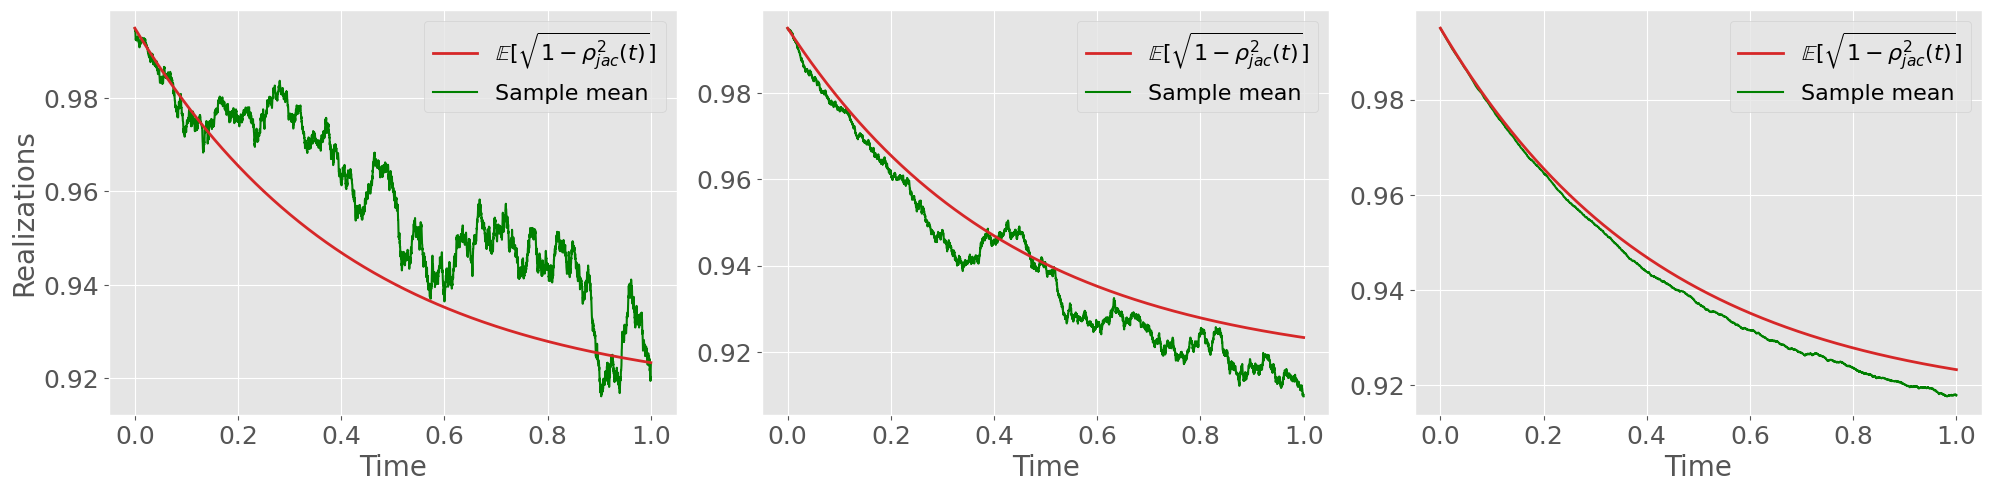

In [184]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

num_samples = [20, 100, 10_000]

for i in range(len(num_samples)):
    time, jacobipath_sqrt = jacobiProcess_sqrt(num_samples[i], 5000, 1, rho0, krho, murho, sigmarho)

    axs[i].set_xlabel('Time')
    axs[0].set_ylabel('Realizations')

    axs[i].plot(time, psi_jac(time), color='tab:red', zorder=3, label=r'$\mathbb{E}[\sqrt{1-\rho_{jac}^2(t)}]$', linewidth=2)
    axs[i].plot(time, np.mean(jacobipath_sqrt, 0), color='green', label='Sample mean')
    axs[i].legend()

plt.tight_layout(pad=1)
plt.subplots_adjust(wspace=0.15)
# plt.savefig('Images/Approx_sqrt_Jacobi_3plots.pdf', dpi=300)
plt.show()

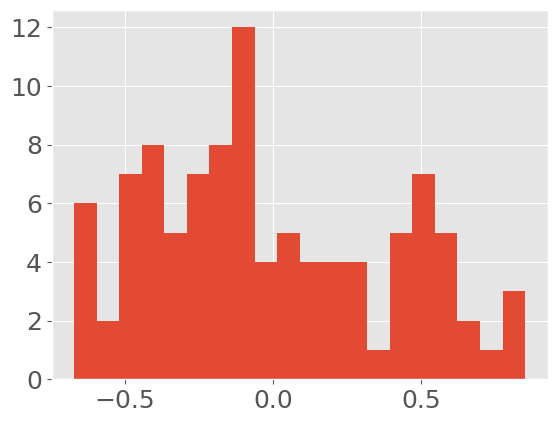

In [129]:
plt.hist(jacobipath[:, -1], bins=20)
plt.show()

## Ornstein-Uhlenbek process

In [204]:
def ornsteinUhlenbekProcess(NumberPaths, N, T, x0, krho, murho, sigmarho):
    Z1 = np.random.normal(0.0, 1.0,[NumberPaths,N])
    X = np.zeros([NumberPaths, N + 1])

    X[:, 0] = x0

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] + krho * (murho - X[:,i]) * dt + sigmarho * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] > 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] < -1)[0], i+1] = -0.9999  
            
        time[i+1] = time[i] + dt

    return time, X

In [205]:
rho0 = 0.1
krho = 1
murho = 0.0
sigmarho = 0.62
time, oupaths = ornsteinUhlenbekProcess(50, 3000, 1, rho0, krho, murho, sigmarho)

In [206]:
var_ou = lambda t: (sigmarho**2)/(2*krho) * (1 - np.exp(-2*krho*t))
exp_ou = lambda t:  np.exp(-krho*t) * (rho0 - murho) + murho

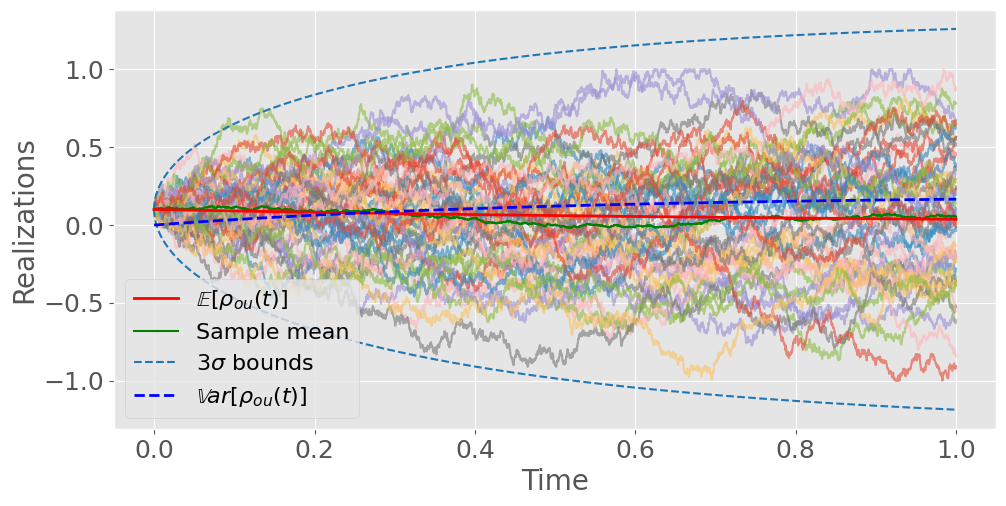

In [207]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(50):
    plt.plot(time, oupaths[i], alpha=0.6)
        
    # plt.title('Ornstein-Uhlenbek Process')
    plt.xlabel('Time')
    plt.ylabel('Realizations')

plt.plot(time, exp_ou(time), color='red', label=r'$\mathbb{E}[\rho_{ou}(t)]$', zorder=3, linewidth=2)
plt.plot(time, np.mean(oupaths, 0), color='green', label='Sample mean')
plt.plot(time, exp_ou(time) + 3 * np.sqrt(var_ou(time)), '--', color='tab:blue', label=r'$3\sigma$ bounds')
plt.plot(time, exp_ou(time) - 3 * np.sqrt(var_ou(time)), '--', color='tab:blue')
plt.plot(time, var_ou(time), '--', color='blue', label=r'$\mathbb{V}ar[\rho_{ou}(t)]$', linewidth=2, zorder=3)


plt.legend()
plt.tight_layout(pad=0.5)

# plt.savefig('Images/3sigma_OU.pdf', dpi=300)
plt.show()

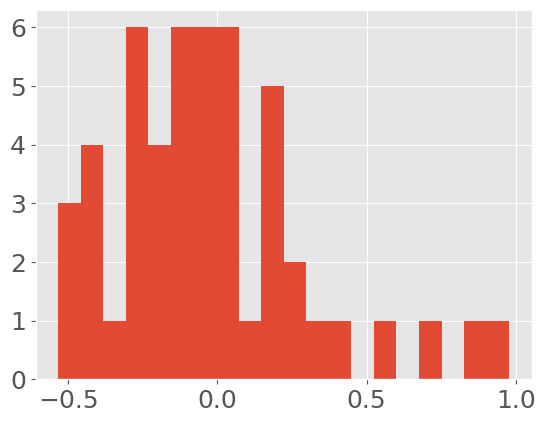

In [94]:
plt.hist(oupaths[:, -1], bins=20)
plt.show()

In [208]:
0.62**2 / (2*krho)

0.1922

In [209]:
1/(theta*(delta+1)) * np.sqrt((2*(delta+1)) / (2*(delta+1) + 1))

0.19069251784911848

## 4. Sine-Wiener Noise

In [97]:
def sine_wiener_noise(NumberPaths, N, T, b):
    X = np.zeros([NumberPaths, N + 1])

    time = np.linspace(0, T, N+1)
    
    X[:] = np.sin(np.sqrt(2/b) * np.sqrt(time) * np.random.normal(0, 1, size=(NumberPaths, N+1)))
    

    return time, X

In [98]:
time, swpaths = sine_wiener_noise(50, 3000, 1, 20)

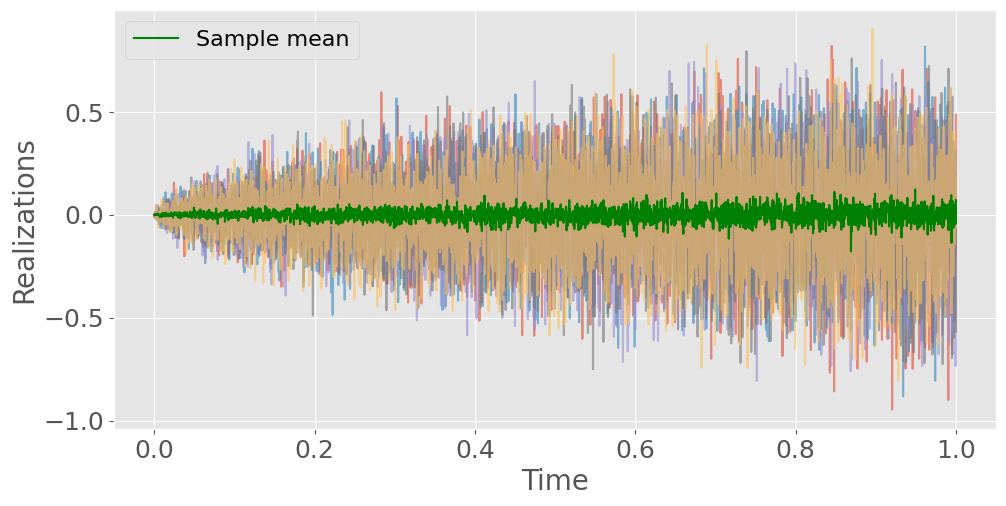

In [99]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(5):
    plt.plot(time, swpaths[i], alpha=0.6)
        
    # plt.title('Ornstein-Uhlenbek Process')
    plt.xlabel('Time')
    plt.ylabel('Realizations')

plt.plot(time, np.mean(swpaths, 0), color='green', label='Sample mean')

plt.legend()
plt.tight_layout(pad=0.5)

# plt.savefig('Images/3sigma_SW.pdf', dpi=300)
plt.show()